In [ ]:
import pandas as pd
diagnoses_df = pd.read_excel('Diagnoses_list.xlsx')
icd10_df = pd.read_html('https://www.icd10data.com/ICD10CM/Codes')[0]
diagnoses_df.head()

(                                      Diagnoses_list
 0  ['Diabetes mellitus without mention of complic...
 1  ['Long-term (current) use of anticoagulants', ...
 2  ['Acute respiratory failure', 'Hypopotassemia'...
 3  ['Antineoplastic and immunosuppressive drugs c...
 4  ['Personal history of malignant neoplasm of to...,
     code                                               desc
 0   A000  Cholera due to Vibrio cholerae 01, biovar chol...
 1   A001    Cholera due to Vibrio cholerae 01, biovar eltor
 2   A009                               Cholera, unspecified
 3  A0100                         Typhoid fever, unspecified
 4  A0101                                 Typhoid meningitis)

In [ ]:
diagnoses_df.dropna(inplace=True)
diagnoses_df['Diagnoses_list'] = diagnoses_df['Diagnoses_list'].str.strip()

icd10_df.dropna(inplace=True)
icd10_df['desc'] = icd10_df['desc'].str.strip()

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
diagnoses_df.dropna(inplace=True)
diagnoses_df.columns = ['Diagnosis']
diagnoses_df['Diagnosis'] = diagnoses_df['Diagnosis'].str.strip()

icd10_df.dropna(inplace=True)
icd10_df.columns = ['code', 'desc']
icd10_df['desc'] = icd10_df['desc'].str.strip()


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L3-v2')


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [24]:
from sentence_transformers import util

results = []

for diag in tqdm(diagnoses_df['Diagnosis']):
    diag_embed = model.encode(diag, convert_to_tensor=True)

    cosine_scores = util.cos_sim(diag_embed, icd_embeddings)[0]
    best_match_idx = torch.argmax(cosine_scores).item()

    best_code = icd10_df.iloc[best_match_idx]['code']
    best_desc = icd10_df.iloc[best_match_idx]['desc']

    results.append({
        "Original diagnosis": diag,
        "Mapped ICD-10 code": best_code,
        "Diagnosis description": best_desc
    })

final_df = pd.DataFrame(results)


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


In [25]:
final_df.to_excel("Final_ICD10_Mapped.xlsx", index=False)

final_df.head()


,Original diagnosis,Mapped ICD-10 code,Diagnosis description
0,['Diabetes mellitus without mention of complic...,E139,Other specified diabetes mellitus without comp...
1,"['Long-term (current) use of anticoagulants', ...",A488,Other specified bacterial diseases
2,"['Acute respiratory failure', 'Hypopotassemia'...",I519,"Heart disease, unspecified"
3,['Antineoplastic and immunosuppressive drugs c...,C800,"Disseminated malignant neoplasm, unspecified"
4,['Personal history of malignant neoplasm of to...,J988,Other specified respiratory disorders


**Top 10 Most Frequently Mapped ICD-10 Codes**




/tmp/ipython-input-26-264687773.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_codes.values, y=top_codes.index, palette="Blues_d")


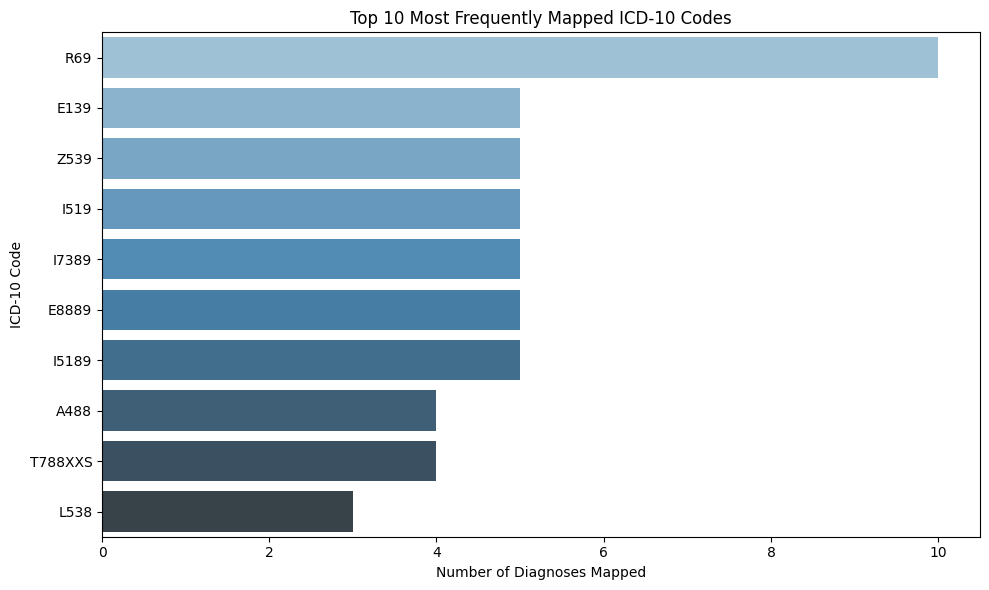

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

top_codes = final_df['Mapped ICD-10 code'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_codes.values, y=top_codes.index, palette="Blues_d")
plt.title("Top 10 Most Frequently Mapped ICD-10 Codes")
plt.xlabel("Number of Diagnoses Mapped")
plt.ylabel("ICD-10 Code")
plt.tight_layout()
plt.show()


**ICD-10 Code Category Distribution**


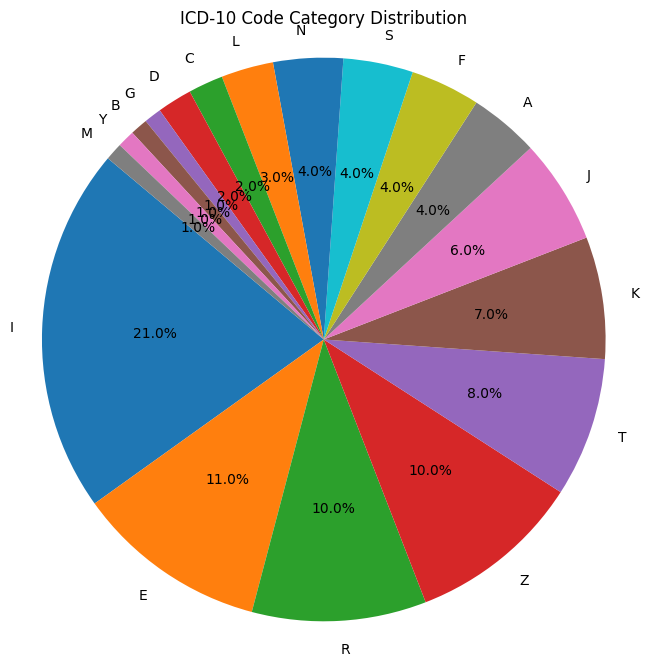

In [27]:
final_df['ICD Category'] = final_df['Mapped ICD-10 code'].str[0]

category_counts = final_df['ICD Category'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("ICD-10 Code Category Distribution")
plt.axis('equal')
plt.show()


**Heatmap of Similar Diagnoses Mapped to the Same ICD Code**

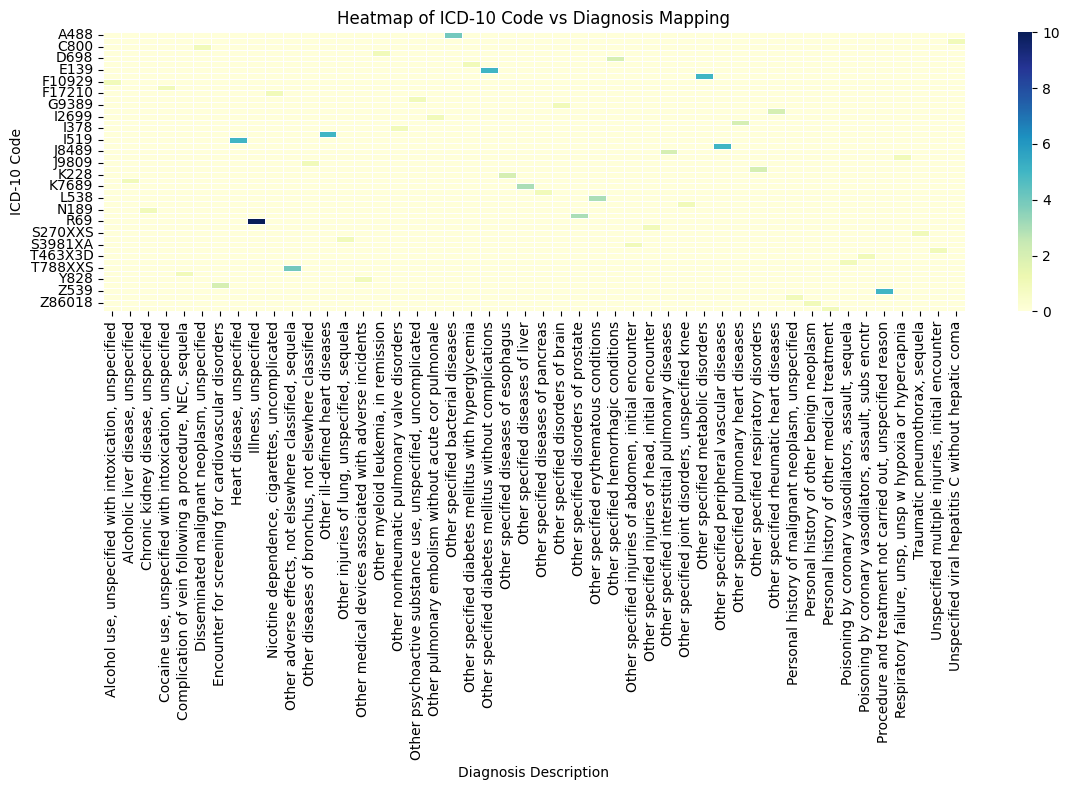

In [28]:
heatmap_data = final_df.groupby(['Mapped ICD-10 code', 'Diagnosis description']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5)
plt.title("Heatmap of ICD-10 Code vs Diagnosis Mapping")
plt.xlabel("Diagnosis Description")
plt.ylabel("ICD-10 Code")
plt.tight_layout()
plt.show()


In [29]:
final_df['Tag'] = final_df['Mapped ICD-10 code'].str[0].map({
    'E': 'Endocrine',
    'I': 'Circulatory',
    'J': 'Respiratory',
    'C': 'Cancer',
    'A': 'Infectious',
    'F': 'Mental Disorders'
}).fillna('Other')
